
经过了`Transformer学习.ipynb`后，我把那里面的代码整理到了`transformer/model.py` 和`transformer/train.py`。

这样这个notebook会看起来比较简洁。主要用来绘图。

然后下面的代码主要是`train.py`的主函数部分

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))  # 把工作路径转到主目录下

In [2]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.__version__

'2.0.0'

In [3]:
from transformer.model import TransformerClassifier
from transformer.train import CustomSchedule

# 训练

## 构建数据集

In [4]:
from utils.preprocess import load_testcnn_data, load_tokenizer_binarizer

# testcnn和transformer预处理的数据是一致的
train_x, dev_x, test_x, train_y, dev_y, test_y = load_testcnn_data()
tokenizer, mlb = load_tokenizer_binarizer()
BUFFER_SIZE = 256
BATCH_SIZE = 128

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=False)

# 流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。
# 没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 设定超参并建模

In [6]:
num_layers = 4
d_model = 128
num_heads = 8
dff = 512
vocab_size = 50000
maximum_position_encoding=10000
output_dim = len(train_y[0])  # 97
dropout_rate = 0.1
# max_seq_len = 128

steps_per_epoch = len(train_x) // BATCH_SIZE + 1
epochs = 10

In [7]:
model = TransformerClassifier(num_layers, d_model, num_heads, dff, vocab_size, 
                                    maximum_position_encoding, output_dim, dropout_rate)

## 学习率

In [8]:
learning_rate = CustomSchedule(d_model)
# 配置优化器
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## 评估指标和损失函数

In [9]:
from utils.metrics import micro_f1, macro_f1, precision_recall
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='auto')

## checkpoint

In [10]:
checkpoint_path = "notebook/Transformer/checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## **Training**

In [11]:
from transformer.train import predict, evaluation, create_padding_mask

之前的训练代码是这样的，但是我为了更好的分析结果。需要把这个代码改动一下

In [12]:
def training():
    # 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
    # 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
    # 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
    # 更多的通用形状。
    # 这里填的128指的是句子的长度
    train_step_signature = [
        tf.TensorSpec(shape=(None, 128), dtype=tf.float32),
        tf.TensorSpec(shape=(None, None), dtype=tf.float32),
    ]

    @tf.function(input_signature=train_step_signature)
    def train_step(x, y):

        enc_padding_mask = create_padding_mask(x)
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True, enc_padding_mask=enc_padding_mask)
            loss = loss_object(y, y_pred)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_loss(loss)
        train_accuracy(y, y_pred)

        mi_f1=micro_f1(y, y_pred)
        ma_f1=macro_f1(y, y_pred)
        return mi_f1, ma_f1, y_pred


    # 训练
    for epoch in range(epochs):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        for batch, (x, y) in enumerate(train_dataset.take(steps_per_epoch)):
            mi_f1 ,ma_f1, _ = train_step(x, y)

            if batch % 20 == 0:
                print('epoch {} batch {:3d} loss {:.4f} acc {:.4f} micro_f1 {:.4f} macro_f1 {:.4f}'.format(
                    epoch+1, batch+1, train_loss.result(), 
                    train_accuracy.result(), mi_f1, ma_f1))
            break
        # 每隔5轮保存一下        
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

        print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
        evaluation(dev_x, dev_y)
        print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))

## 训练

In [13]:
train_step_signature = [
    tf.TensorSpec(shape=(None, 128), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(x, y):

    enc_padding_mask = create_padding_mask(x)
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True, enc_padding_mask=enc_padding_mask)
        loss = loss_object(y, y_pred)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y, y_pred)
    
    return y_pred

loss_record = []
# 为了之后绘制曲线
dev_metrics = []
train_metrics = []

for epoch in range(epochs):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    train_y_true = []
    train_y_pred = []
    
    
    for batch, (x, y) in enumerate(train_dataset.take(steps_per_epoch)):
        y_pred = train_step(x, y)
        train_y_pred.append(y_pred)
        train_y_true.append(y)
        if batch % 50 == 0:
            print('epoch {} batch {:3d} loss {:.4f}'.format(
                epoch+1, batch+1, train_loss.result()))
            
    loss_record.append(train_loss.result().numpy())  # 记录下每轮loss的变化
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    
    dev_y_true = tf.cast(dev_y, tf.float32)
    dev_y_pred = predict(model, dev_x)
    
    train_y_true = tf.concat(train_y_true, axis=0)
    train_y_pred = tf.concat(train_y_pred, axis=0)
    
    dev_precision, dev_recall = precision_recall(dev_y_true, dev_y_pred)
    dev_micro_f1 = micro_f1(dev_y_true, dev_y_pred)
    dev_macro_f1 = macro_f1(dev_y_true, dev_y_pred)
    
    train_precision, train_recall = precision_recall(train_y_true, train_y_pred)
    train_micro_f1 = micro_f1(train_y_true, train_y_pred)
    train_macro_f1 = macro_f1(train_y_true, train_y_pred)
    
    dev_metrics.append([dev_precision.numpy(), dev_recall.numpy(), 
                        dev_micro_f1.numpy(), dev_macro_f1.numpy()])
    
    train_metrics.append([train_precision.numpy(), train_recall.numpy(), 
                          train_micro_f1.numpy(), train_macro_f1.numpy()])
    
    print('dev precision {:.4f} recall {:.4f} micro f1 {:.4f} macro f1 {:.4f}'.format(
            dev_precision, dev_recall, dev_micro_f1, dev_macro_f1))
    
    print('train precision {:.4f} recall {:.4f} micro f1 {:.4f} macro f1 {:.4f}'.format(
            train_precision, train_recall, train_micro_f1, train_macro_f1))
    
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))

epoch 1 batch   1 loss 0.9150
epoch 1 batch  51 loss 0.4988
epoch 1 batch 101 loss 0.3292
Epoch 1 Loss 0.2699
dev precision 0.7106 recall 0.1080 micro f1 0.1875 macro f1 0.0147
train precision 0.0788 recall 0.0915 micro f1 0.0847 macro f1 0.0290
Time taken for 1 epoch 55.27 sec

epoch 2 batch   1 loss 0.1425
epoch 2 batch  51 loss 0.1284
epoch 2 batch 101 loss 0.1143
Epoch 2 Loss 0.1025
dev precision 0.8436 recall 0.5694 micro f1 0.6799 macro f1 0.3080
train precision 0.8676 recall 0.3155 micro f1 0.4627 macro f1 0.1273
Time taken for 1 epoch 40.88 sec

epoch 3 batch   1 loss 0.0730
epoch 3 batch  51 loss 0.0624
epoch 3 batch 101 loss 0.0565
Epoch 3 Loss 0.0522
dev precision 0.8507 recall 0.7773 micro f1 0.8124 macro f1 0.6107
train precision 0.8947 recall 0.6399 micro f1 0.7462 macro f1 0.4640
Time taken for 1 epoch 40.18 sec

epoch 4 batch   1 loss 0.0393
epoch 4 batch  51 loss 0.0388
epoch 4 batch 101 loss 0.0371
Epoch 4 Loss 0.0350
dev precision 0.8673 recall 0.8162 micro f1 0.8410

# 绘图

In [14]:
import pandas as pd

In [15]:
# history = pd.read_csv('notebook/Transformer/transformer_report.csv')

In [16]:
history = pd.DataFrame(np.concatenate([dev_metrics, train_metrics], axis=1),
                        columns=['dev_precision', 'dev_recall', 'dev_micro_f1', 'dev_macro_f1',
                                 'train_precision', 'train_recall', 'train_micro_f1', 'train_macro_f1'])

In [17]:
history.index += 1
history

,dev_precision,dev_recall,dev_micro_f1,dev_macro_f1,train_precision,train_recall,train_micro_f1,train_macro_f1
1,0.710552,0.107983,0.187476,0.014730,0.078795,0.091452,0.084653,0.029014
2,0.843607,0.569358,0.679867,0.307979,0.867553,0.315513,0.462737,0.127267
3,0.850693,0.777331,0.812359,0.610683,0.894702,0.639930,0.746168,0.463982
4,0.867317,0.816205,0.840985,0.686140,0.913005,0.773923,0.837731,0.665046
5,0.830734,0.864760,0.847406,0.756386,0.923346,0.836141,0.877582,0.765086
6,0.704295,0.864512,0.776223,0.745042,0.936293,0.869865,0.901857,0.821359
7,0.893752,0.862824,0.878016,0.790739,0.940403,0.889243,0.914108,0.857508
8,0.873908,0.894300,0.883987,0.820166,0.948741,0.905036,0.926373,0.876720
9,0.902376,0.869179,0.885466,0.816779,0.956480,0.920840,0.938322,0.902797
10,0.893351,0.894549,0.893950,0.832097,0.957914,0.924662,0.940994,0.908318


In [18]:
import matplotlib.pyplot as plt

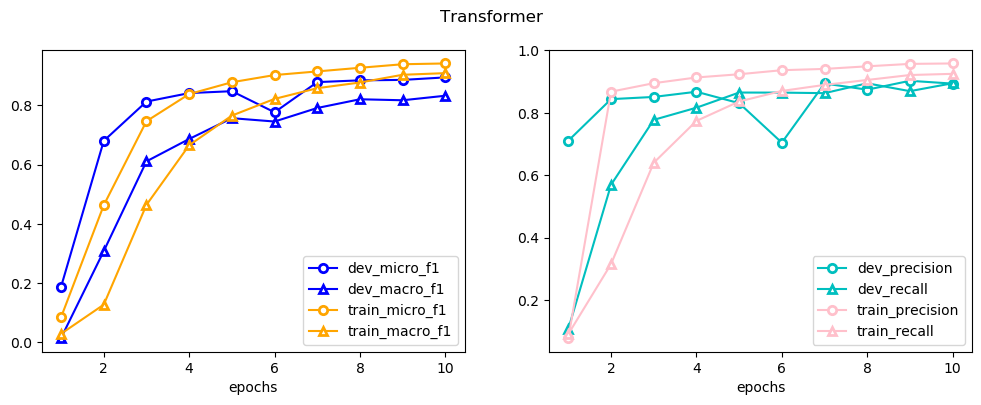

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), dpi=100)
ax[0].plot(history.dev_micro_f1, c='b', marker='o', mfc='w', mew=2, label='dev_micro_f1')
ax[0].plot(history.dev_macro_f1, c='b', marker='^', mfc='w', mew=2, label='dev_macro_f1')
ax[0].plot(history.train_micro_f1, c='orange', marker='o', mfc='w', mew=2, label='train_micro_f1')
ax[0].plot(history.train_macro_f1, c='orange', marker='^', mfc='w', mew=2, label='train_macro_f1')
ax[0].set_xlabel('epochs')
ax[0].legend()

ax[1].plot(history.dev_precision, c='c', marker='o', mfc='w', mew=2, label='dev_precision')
ax[1].plot(history.dev_recall, c='c', marker='^', mfc='w', mew=2, label='dev_recall')
ax[1].plot(history.train_precision, c='pink', marker='o', mfc='w', mew=2, label='train_precision')
ax[1].plot(history.train_recall, c='pink', marker='^', mfc='w', mew=2, label='train_recall')
ax[1].set_xlabel('epochs')
ax[1].legend()
fig.suptitle('Transformer')
plt.show()

In [20]:
history.to_csv('notebook/Transformer/transformer_report.csv', index=None)

# 预测

In [21]:
# y_pred = np.load('notebook/Transformer/test_y_pred.npy')
y_pred = predict(model, test_x)
test_micro_f1 = micro_f1(test_y, y_pred)
test_macro_f1 = macro_f1(test_y, y_pred)
test_precision, test_recall = precision_recall(test_y, y_pred)

In [22]:
np.save('notebook/Transformer/test_y_pred.npy', y_pred)

In [23]:
print('test micro f1: {:.4f} macro f1: {:.4f}'.format(
    test_micro_f1, test_macro_f1))

print('test precision: {:.4f} recall: {:.4f}'.format(
    test_precision, test_recall))

test micro f1: 0.8858 macro f1: 0.8200
test precision: 0.8860 recall: 0.8857


## metrics
- TP : 预测是正样本，且实际也是正样本
- recall : TP / 实际是正样本
- precision : TP / 预测是正样本